<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Keras implementation of SHAP explanation algorithm for image classification task on NEU surface defect database.**

#Initialization

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from skimage.segmentation import mark_boundaries
from xml.etree import ElementTree

# !pip install q keras==2.3.1

Using TensorFlow backend.


In [0]:
%cd /content/drive/My Drive/xai_model

keras.__version__

'2.2.5'

In [0]:
# Load a pretrained model for evaluation

saved_model = load_model('LG_model.h5')
saved_model.summary()

In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

Predicted Class :  [5]
Output :  Scratches


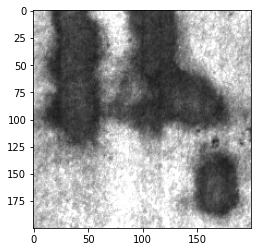

In [0]:
# Load the image along ground truth annotation.

annotation = '/content/drive/My Drive/NEU surface defect database - test split/ANNOTATIONS/patches_108.xml'
image_path = "/content/drive/My Drive/NEU surface defect database - test split/Test/Pa/Pa_108.bmp"

img = image.load_img(image_path, target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
# img /= 255
result = saved_model.predict(img)

prediction = result.argmax(axis=-1)
print("Predicted Class : ",prediction)
output = labels[int(prediction)]
print("Output : ",output)

[[8, 1, 64, 122], [75, 1, 177, 111], [145, 117, 190, 187]]


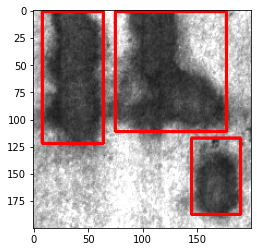

In [0]:
b_img = cv2.imread(image_path)

def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

boxes = extract_boxes(annotation)
print(boxes)

for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  #print(pt1, pt2)
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [0]:
shap_Cr = '/content/drive/My Drive/NEU surface defect database - test split/Train/Cr/*.bmp'
shap_In = '/content/drive/My Drive/NEU surface defect database - test split/Train/In/*.bmp'
shap_PS = '/content/drive/My Drive/NEU surface defect database - test split/Train/PS/*.bmp'
shap_Pa = '/content/drive/My Drive/NEU surface defect database - test split/Train/Pa/*.bmp'
shap_RS = '/content/drive/My Drive/NEU surface defect database - test split/Train/RS/*.bmp'
shap_Sc = '/content/drive/My Drive/NEU surface defect database - test split/Train/Sc/*.bmp'

shap_data = [shap_Cr, shap_In, shap_PS, shap_Pa, shap_RS, shap_Sc]

In [0]:
%%time
import glob
cv_img = []

for i in range(len(shap_data)):
  for ig in glob.glob(shap_data[i]):
    n = cv2.imread(ig)
    cv_img.append(n)

shap_background = np.array(cv_img)

# np.save('/content/drive/My Drive/XAI_results/shap_background_all.npy', shap_background)

# shap_background_train = np.load('/content/drive/My Drive/XAI_results/shap_background_train.npy')  #shap_background_all

CPU times: user 471 ms, sys: 501 ms, total: 972 ms
Wall time: 4min 41s


In [0]:
shap_background = shap_background.astype('float32')
shap_background = shap_background.reshape(shap_background.shape[0], 200 , 200 , 3)

In [0]:
image_path = "/content/drive/My Drive/NEU surface defect database - test split/Test/Pa/Pa_167.bmp"

shap_test = image.load_img(image_path) 
plt.imshow(shap_test)

shap_test = image.img_to_array(shap_test)
shap_test = np.expand_dims(shap_test, axis=0)
shap_test /= 255
shap_test = preprocess_input(shap_test)
shap_test.shape

test_img = cv2.imread(image_path)
test_img = test_img.astype('float32')
test_img = test_img.reshape(1, 200, 200, 3)

# SHAP algorithm

In [0]:
pip install shap

In [0]:
import shap

explainer = shap.GradientExplainer(saved_model, [shap_background, shap_background])

shap_values = explainer.shap_values([test_img, test_img])

In [0]:
sess = tf.Session()
sess.run(tf.local_variables_initializer())      # tf.initialize_all_variables()
sess.run(tf.initialize_all_variables()) 
sess.run(tf.global_variables_initializer())

In [0]:
K.set_session(tf.Session(graph=saved_model.output.graph)) 
# init = tf.global_variables_initializer() 
init = tf.initialize_all_variables()
K.get_session().run(init)

In [0]:
%%time
import keras.backend as K
import shap
m = 7

sess = tf.compat.v1.Session()

# with sess.as_default(): 
#   assert tf.compat.v1.get_default_session() is sess

K.set_session(tf.Session)

def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((saved_model.layers[m].input, saved_model.layers[-1].output),
                          map2layer((shap_background_train.copy()),m), local_smoothing = 0)    #shap_background.copy()  shap_background_train.copy()

shap_values, indexes = e.shap_values(map2layer(shap_test, m), ranked_outputs=3)

index_names = np.vectorize(lambda l: labels[l])(indexes)

shap.image_plot(shap_values, shap_test, index_names, show=False)

# IoU calculation

In [0]:
sv_p = np.zeros(sv.shape)
for i in range(sv.shape[0]):
  for j in range(sv.shape[1]):
    if sv[i][j] < 0:
      sv_p[i][j] = 0
    else:
      sv_p[i][j] = sv[i][j]

sv_p = sv_p / np.amax(sv_p)

for i in range(sv_p.shape[0]):
  for j in range(sv_p.shape[1]):
    if sv_p[i][j] > 0.25:
      sv_p[i][j] = 1
    else:
      sv_p[i][j] = 0

shap_mask = np.zeros((sv_p.shape[0],sv_p.shape[1],3))
for i in range(svs[0]):
  for j in range(svs[1]):
    if sv_p[i][j] == 1:
      shap_mask[i][j] = 255
    else:
      shap_mask[i][j] = 0

shap_mask_r = cv2.resize(shap_mask, (200, 200))   # SHAP explanation mask

gt_mask = np.zeros(b_img.shape)

for l in range(len(boxes)):
  for i in range(boxes[l][1], boxes[l][3]):
    for j in range(boxes[l][0], boxes[l][2]):
      gt_mask[i][j] = 255 

gt_mask = cv2.resize(gt_mask, (shap_mask.shape[0],shap_mask.shape[1]))   # Ground Truth bounding box

In [0]:
intersection=[]
union=[]

intersection = np.logical_and(gt_mask, shap_mask_r)
union = np.logical_or(gt_mask, shap_mask_r)
iou_score = np.sum(intersection) / np.sum(union)
print("SHAP IOU: ",iou_score)

SHAP IOU:  0.027858703568827387


#mIOU

mIoU calculation of SHAP algorithm on the NEU surface defect database.

In [0]:
# NOTE: CHANGE INPUTS HERE

x = 4

labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

In [0]:
path_ROOT = '/content/drive/My Drive/NEU surface defect database - test split/Test/'

path_Cr = path_ROOT+'Cr'
path_In = path_ROOT+'In'
path_PS = path_ROOT+'PS'
path_Pa = path_ROOT+'Pa'
path_RS = path_ROOT+'RS'
path_Sc = path_ROOT+'Sc'

gt_path_ROOT = '/content/drive/My Drive/NEU surface defect database - test split/GT Test_2/'

gt_path_Cr = gt_path_ROOT+'Cr'
gt_path_In = gt_path_ROOT+'In'
gt_path_PS = gt_path_ROOT+'PS'
gt_path_Pa = gt_path_ROOT+'Pa'
gt_path_RS = gt_path_ROOT+'RS'
gt_path_Sc = gt_path_ROOT+'Sc'

In [0]:
test_path_list = [path_Cr, path_In, path_PS, path_Pa, path_RS, path_Sc]
gt_path_list = [gt_path_Cr, gt_path_In, gt_path_PS, gt_path_Pa, gt_path_RS, gt_path_Sc]

path = test_path_list[x]
Idx = x
gt_path = gt_path_list[x]

In [0]:
test_files = []
for r, d, f in os.walk(path):
  for file in f:
    if '.bmp' in file:
      test_files.append(os.path.join(r, file))

gt_files = []
for r, d, f in os.walk(gt_path):
  for file in f:
    if '.bmp' in file:
      gt_files.append(os.path.join(r, file))

In [0]:
%%time

import keras.backend as K
import shap

shap_background_train = np.load('/content/drive/My Drive/XAI_results/shap_background_train.npy')
# print(shap_background_train.shape)

def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

miou_score_rs = []

for chosen_layer in range(0,85,5):
  intersection = []
  union = []

  print(chosen_layer, saved_model.layers[chosen_layer])
  e = shap.GradientExplainer((saved_model.layers[chosen_layer].input, saved_model.layers[-1].output),    
                        map2layer(shap_background_train.copy(),chosen_layer), local_smoothing = 0)     #shap_background_all.copy()

  for ttf in range(15):
    pop = os.path.basename(test_files[ttf])
    for gtf in range(len(gt_files)):
      if pop in gt_files[gtf]:
              
        # print(test_files[ttf])
        shap_test = image.load_img(test_files[ttf])  
        shap_test = image.img_to_array(shap_test)
        shap_test = np.expand_dims(shap_test, axis=0)
              
        shap_values, indexes = e.shap_values(map2layer(shap_test, chosen_layer), ranked_outputs=6)

        # print("1")
        index_names = np.vectorize(lambda l: labels[l])(indexes)
        # shap.image_plot(shap_values, shap_test, index_names)
        u = list(indexes[0]).index(Idx)
        print(shap_values[u][0].shape)
        sv = shap_values[u][0].sum(-1)
        
        # print("2")
        sv_p = np.zeros(sv.shape)
        for i in range(sv.shape[0]):
          for j in range(sv.shape[1]):
            if sv[i][j] < 0:
              sv_p[i][j] = 0
            else:
              sv_p[i][j] = sv[i][j]

        # print("3")
        sv_p = sv_p / np.amax(sv_p)
        for i in range(sv_p.shape[0]):
          for j in range(sv_p.shape[1]):
            if sv_p[i][j] > 0.25:
              sv_p[i][j] = 1
            else:
              sv_p[i][j] = 0

        # print("4")
        shap_mask = np.zeros((sv_p.shape[0],sv_p.shape[1],3))  
        for i in range(sv_p.shape[0]):
          for j in range(sv_p.shape[1]):
            if sv_p[i][j] == 1:
              shap_mask[i][j] = 255
            else:
              shap_mask[i][j] = 0

        # print("5")
        shap_mask_r = cv2.resize(shap_mask, (200, 200))

        # print(gt_files[gtf])
        grnd_truth = image.load_img(gt_files[gtf])  
        grnd_truth = image.img_to_array(grnd_truth)

        intrxn = np.logical_and(grnd_truth, shap_mask_r)
        intersection.append(intrxn)
        # print("6")

        unn = np.logical_or(grnd_truth,shap_mask_r)
        union.append(unn)
        # print("7")

  miou = np.sum(intersection) / np.sum(union)
  miou_score_rs.append(miou)
  print("mIOU of "+os.path.basename(gt_path)+", for layer "+str(chosen_layer)+" is :","%.4f" % miou)

print("Done") 
    

In [0]:
# np.save('/content/drive/My Drive/xai_model/shap_miou_score_sc',miou_score_sc) 
# np.save('/content/drive/My Drive/xai_model/shap_miou_score_cr',miou_score_cr) 
# np.save('/content/drive/My Drive/xai_model/shap_miou_score_in',miou_score_in) 
# np.save('/content/drive/My Drive/xai_model/shap_miou_score_ps',miou_score_ps)     
# np.save('/content/drive/My Drive/xai_model/shap_miou_score_pa',miou_score_pa)    
# np.save('/content/drive/My Drive/xai_model/shap_miou_score_rs',miou_score_rs) 

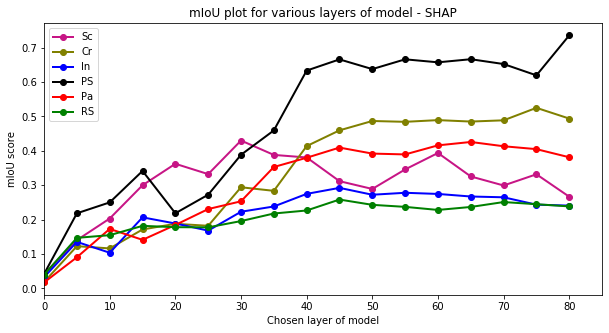

In [0]:
shap_miou_score_sc = np.load('/content/drive/My Drive/xai_model/shap_miou_score_sc.npy')
shap_miou_score_cr = np.load('/content/drive/My Drive/xai_model/shap_miou_score_cr.npy')
shap_miou_score_in = np.load('/content/drive/My Drive/xai_model/shap_miou_score_in.npy')
shap_miou_score_ps = np.load('/content/drive/My Drive/xai_model/shap_miou_score_ps.npy')
shap_miou_score_pa = np.load('/content/drive/My Drive/xai_model/shap_miou_score_pa.npy')
shap_miou_score_rs = np.load('/content/drive/My Drive/xai_model/shap_miou_score_rs.npy')

df = pd.DataFrame({'x': range(0,85,5), 'Sc': shap_miou_score_sc,'Cr': shap_miou_score_cr, 'In': shap_miou_score_in,
                   'PS': shap_miou_score_ps, 'Pa' : shap_miou_score_pa, 'RS' : shap_miou_score_rs})
plt.figure(figsize=(10,5))
plt.title('mIoU plot for various layers of model - SHAP')
# plt.text()
plt.plot( 'x', 'Sc', data=df, marker='o', color='mediumvioletred', linewidth = 2)
plt.plot( 'x', 'Cr', data=df, marker='o', color='olive', linewidth = 2)
plt.plot( 'x', 'In', data=df, marker='o', color='blue', linewidth = 2)
plt.plot( 'x', 'PS', data=df, marker='o', color='black', linewidth = 2)
plt.plot( 'x', 'Pa', data=df, marker='o', color='red', linewidth = 2)
plt.plot( 'x', 'RS', data=df, marker='o', color='green', linewidth = 2)
plt.xlabel('Chosen layer of model')
plt.xlim(0,85)
plt.ylabel('mIoU score')
# plt.ylim(0,max(miou_score)+0.1)  
plt.legend()

plt.show()

**mIOU for SHAP**:


```
chosen_layer = 16
```


Crazing : 0.1667

Inclusion : 0.1687

Pitted Surface : 0.3363

Patches : 0.1076

Rolled-in Scale : 0.1917

Scratches : 0.2563


